# Example CHART analysis notebook

This notebook is a general reference to learn how to look at CHART data.

To do the basic analysis, simply paste the name of your observation for the `obs_name` variable, and run all cells. Some of the later cells may or may not apply to your data.

If you are going to do more in-depth analysis, you may want to copy this notebook so you can keep the original as a reference. You can always find the master copy at https://github.com/astrochart/CHART/blob/master/analysis/example_analysis.ipynb

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import chart

Assign your run to `obs_name`.

In [2]:
obs_name = 'abeardsley_LostDutchman_2019.8.4_2_08:36_pm'
data_dir = '/data/'
data, meta = chart.analysis.read_run(directory=data_dir + obs_name)
nfiles = len(data)
data = np.array(data)
chart.analysis.print_meta(meta[0])

int_length :	 100
samp_rate :	 2000000.0
data_file :	 b'/home/ses330/data_lost_dutchman_v2/2019-08-01_14-21-04.190784.dat'
start_time :	 1564694463.690029
Number of time integrations:	500
frequency :	 1400000000
end_time :	 1564694490.05488
date :	 b'2019-08-01'
vector_length :	 1024
metadata_file :	 b'/home/ses330/data_lost_dutchman_v2/2019-08-01_14-21-04.190784.metadata.npz'


Above we printed the first metadata file, which includes some general information about the observation.
Remember that the data is collected by tuning into one frequency, collecting data and storing in a file, then switching to another frequency and storing to a new file. So each file will have different frequencies and different times.
You can print other metadata files if you want, but only the times and frequency will change.

Below we start looking at our raw data. The first plot is a "waterfall" which shows the intensity of the radio data as a function of time and frequency.
The waterfall is for a single file. You can look at other files by changing the `i` variable.

<IPython.core.display.Javascript object>


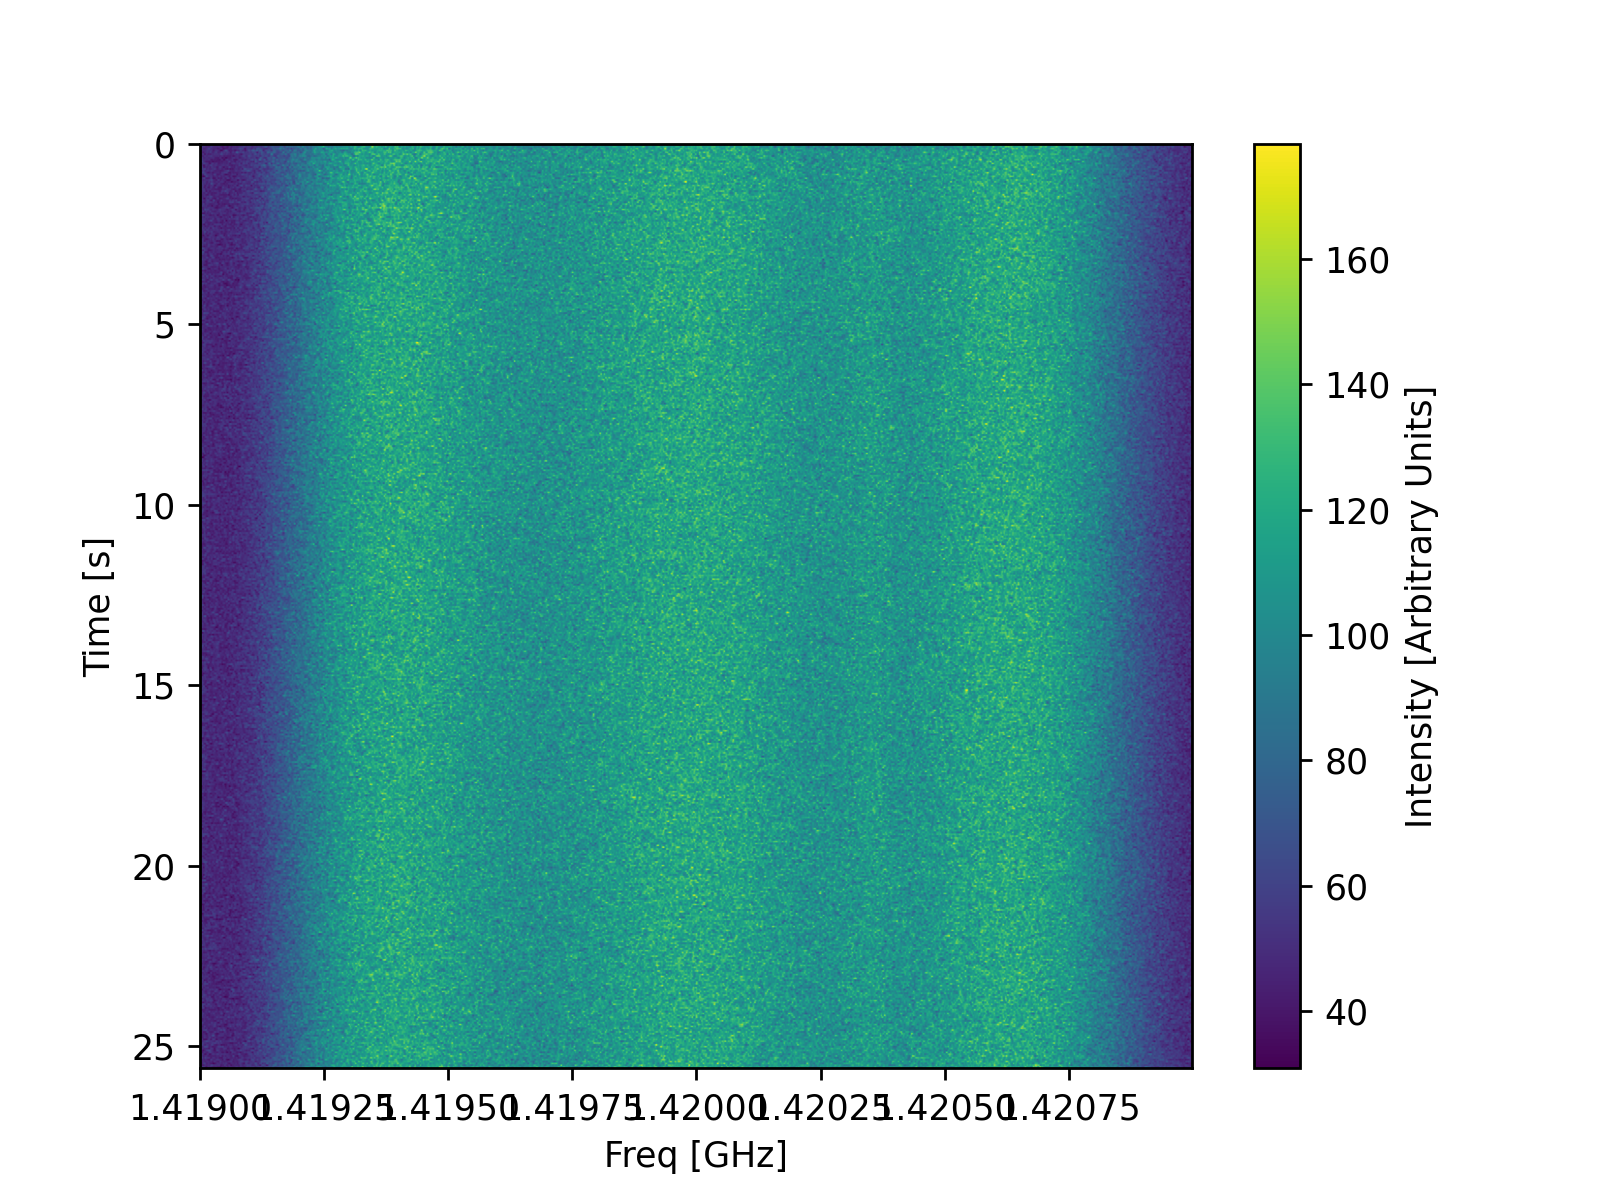

Text(0, 0.5, 'Time [s]')

In [3]:
# Waterfall for one of the files
i = nfiles // 2  # Change this to whichever file number you want to look at
plt.figure(f'Data Waterfall, i={i}')
frequencies = ((np.arange(meta[i]['vector_length']) - meta[i]['vector_length'] / 2)
                       * meta[i]['samp_rate'] / meta[i]['vector_length'] + meta[i]['frequency'])
frequencies = 1e-9 * frequencies  # convert to GHz

dt = meta[i]['vector_length'] * meta[i]['int_length'] / meta[i]['samp_rate']
times = np.arange(len(meta[i]['times']))

plt.imshow(data[i], aspect='auto', extent=[frequencies[0], frequencies[-1], len(times) * dt, 0])
plt.colorbar(label='Intensity [Arbitrary Units]')
plt.xlabel('Freq [GHz]')
plt.ylabel('Time [s]')

Now let's "collapse" the time axis by taking an average. In other words, we are going to average across each frequency column in the waterfall above. This will leave us with a single intensity and each frequency (other than overlapping files).

We also introduce the option to plot in decibel (dB) units, which is a logarithmic scale. If you want to plot in linear units, change the variable `use_db` to `False`.

<IPython.core.display.Javascript object>


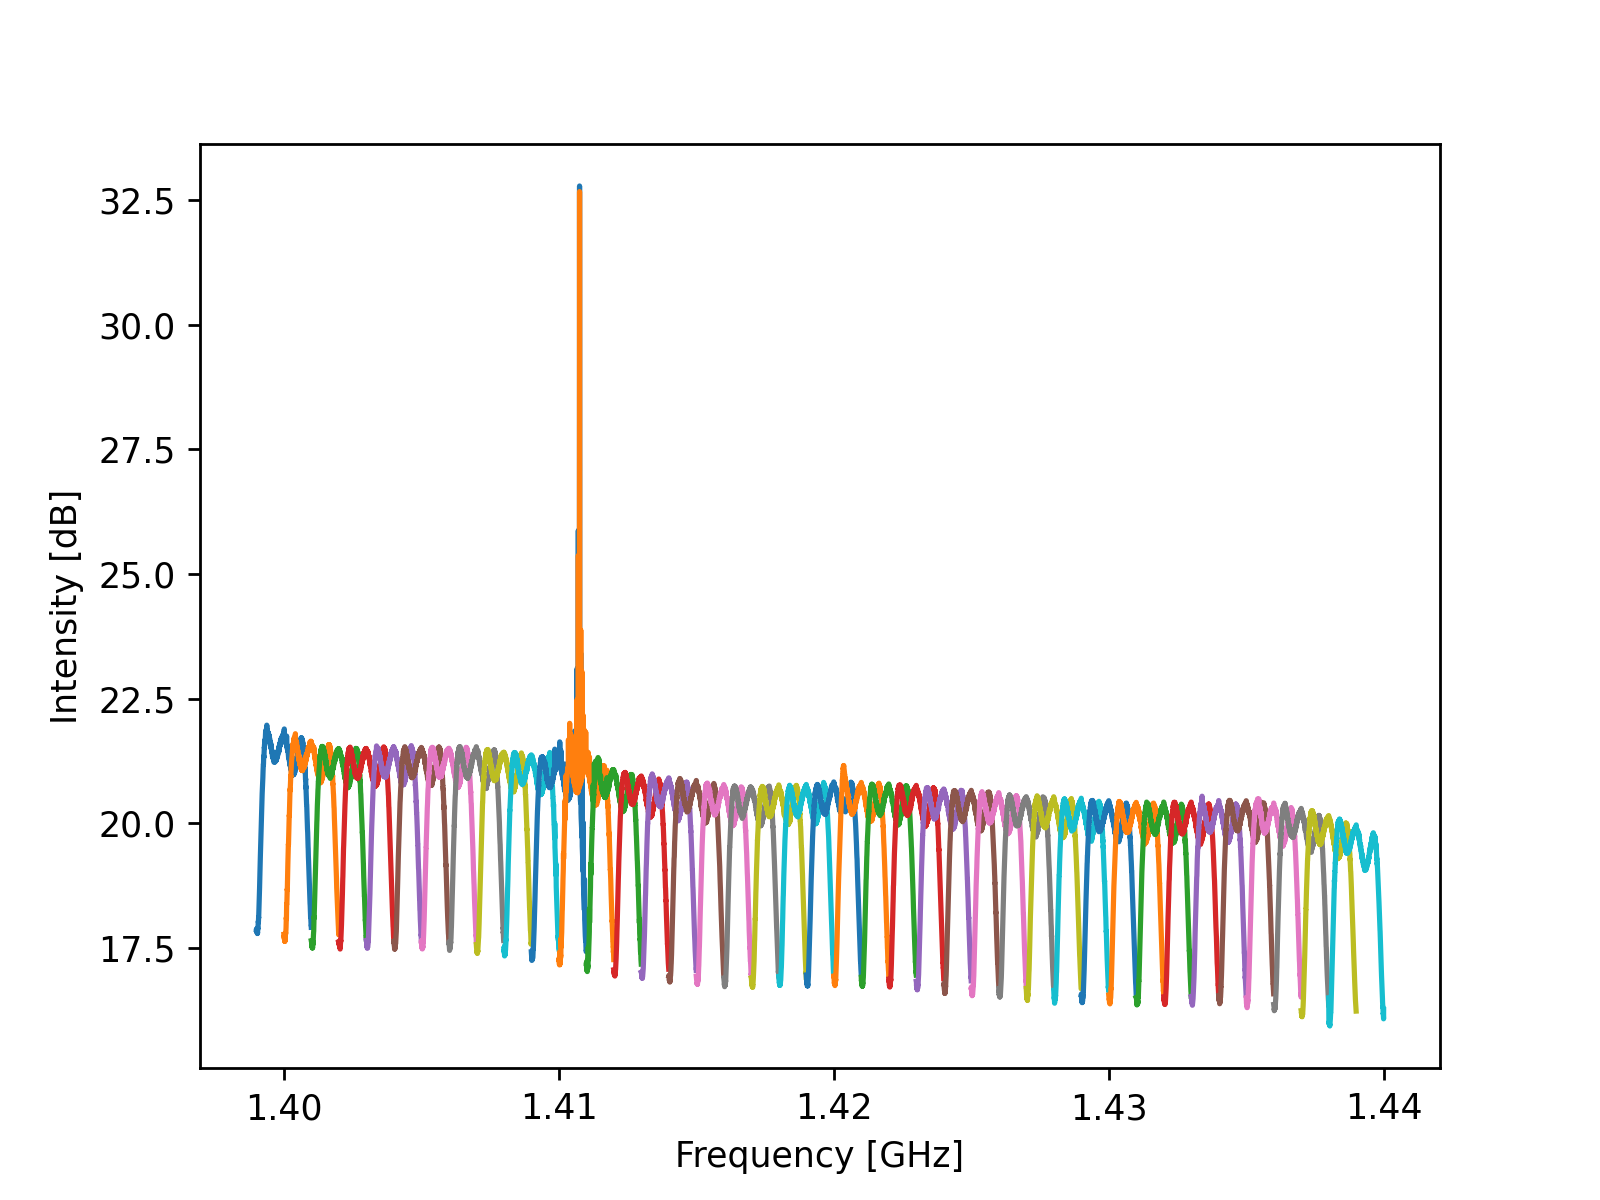

In [4]:
use_db = True

plt.figure('Raw spectra')

for d, m in zip(data, meta):
    spectrum = np.mean(d, axis=0)
    if use_db:
        spectrum = 10 * np.log10(spectrum)
    frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                       * m['samp_rate'] / m['vector_length'] + m['frequency'])
    frequencies = 1e-9 * frequencies
    plt.plot(frequencies, spectrum)
    
plt.xlabel('Frequency [GHz]')
if use_db:
    plt.ylabel('Intensity [dB]')
else:
    plt.ylabel('Intensity [Arb. Units]')

Each colored line above is a different file. You can see how the observed frequency shifts over throughout the observation. You can also see each file starts low, goes up, has some wiggles, and then goes back down.
That general shape is due to some filtering that the radio does, and we need to remove it.

_Tip_: You can zoom and pan around the plot using the tools at the bottom of the figure. 

We "measure" the shape using our data below and call it `bp` for "bandpass."

In [5]:
# Rough estimate for bandpass
nchans = meta[0]['vector_length']
levels = np.median(data[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
rescaled = data / levels.reshape(-1, 1, 1)
bp = np.median(rescaled, axis=(0, 1))

<IPython.core.display.Javascript object>


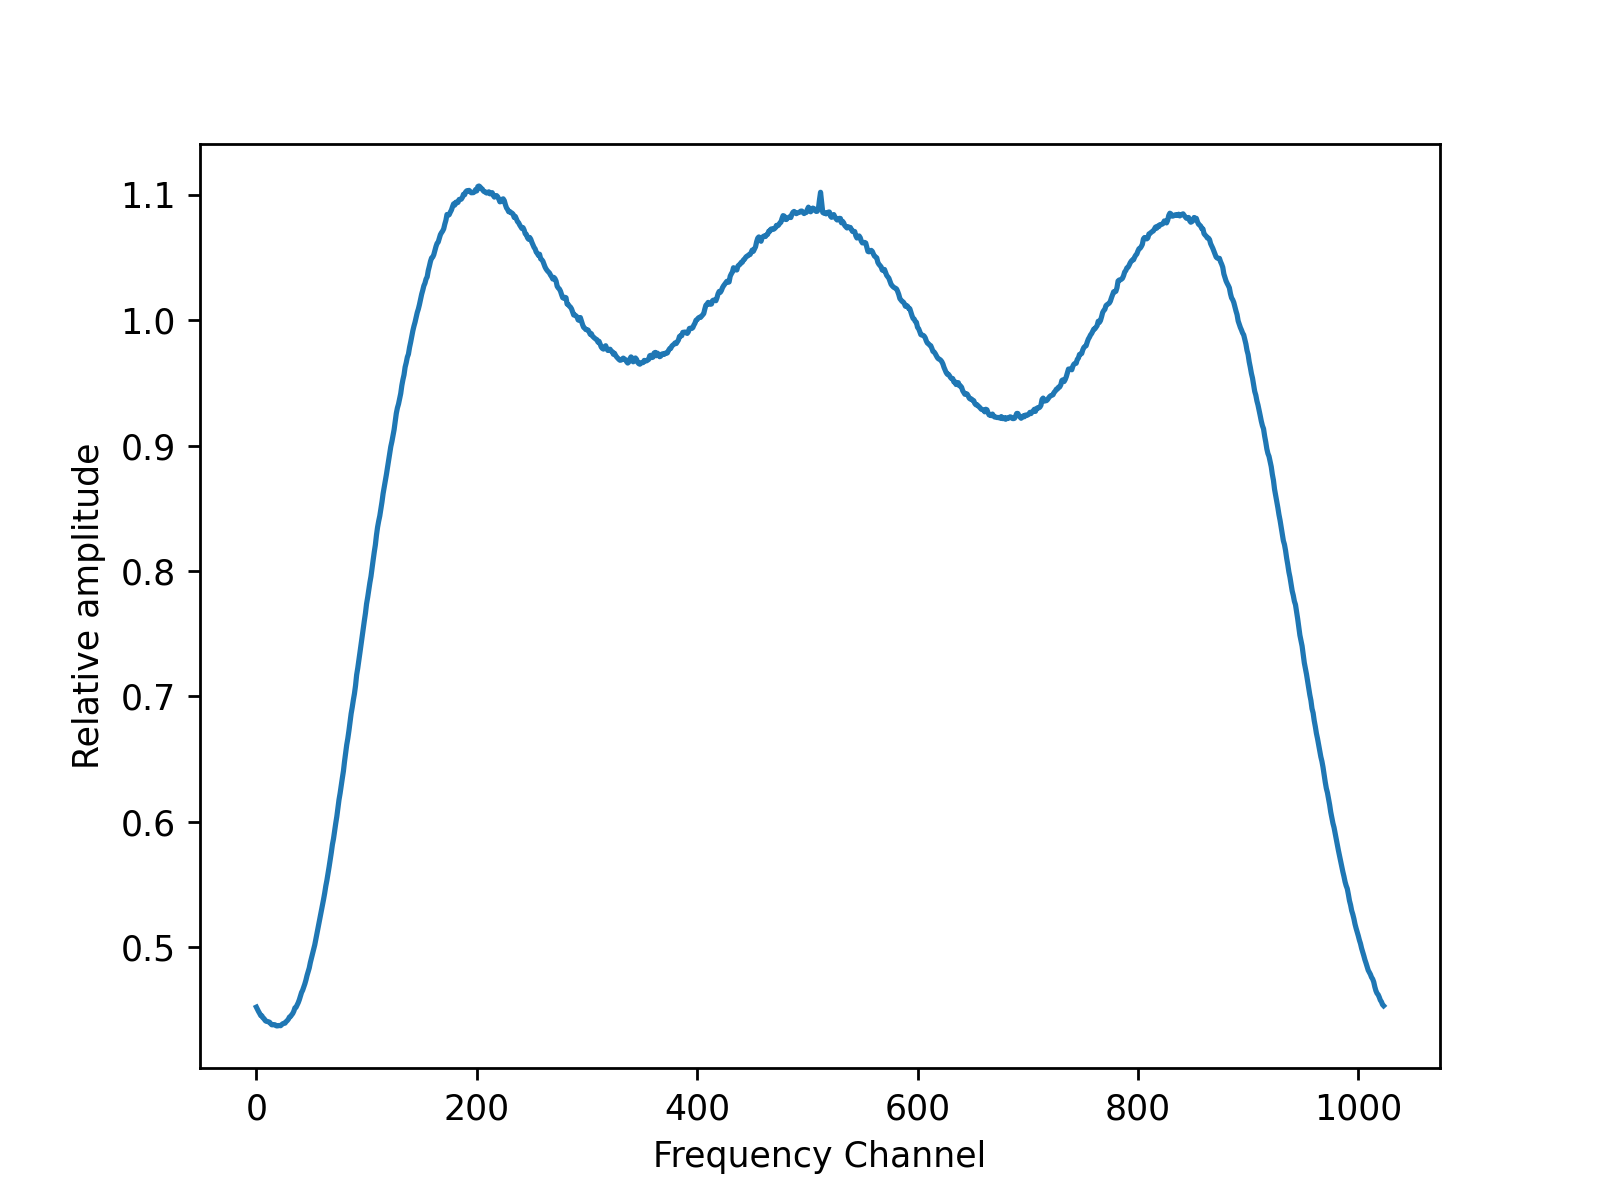

Text(0, 0.5, 'Relative amplitude')

In [6]:
plt.figure('Measured Bandpass')
plt.plot(bp)
plt.xlabel('Frequency Channel')
plt.ylabel('Relative amplitude')

Next we "calibrate" the data by dividing out the bandpass from each file's spectrum.

<IPython.core.display.Javascript object>


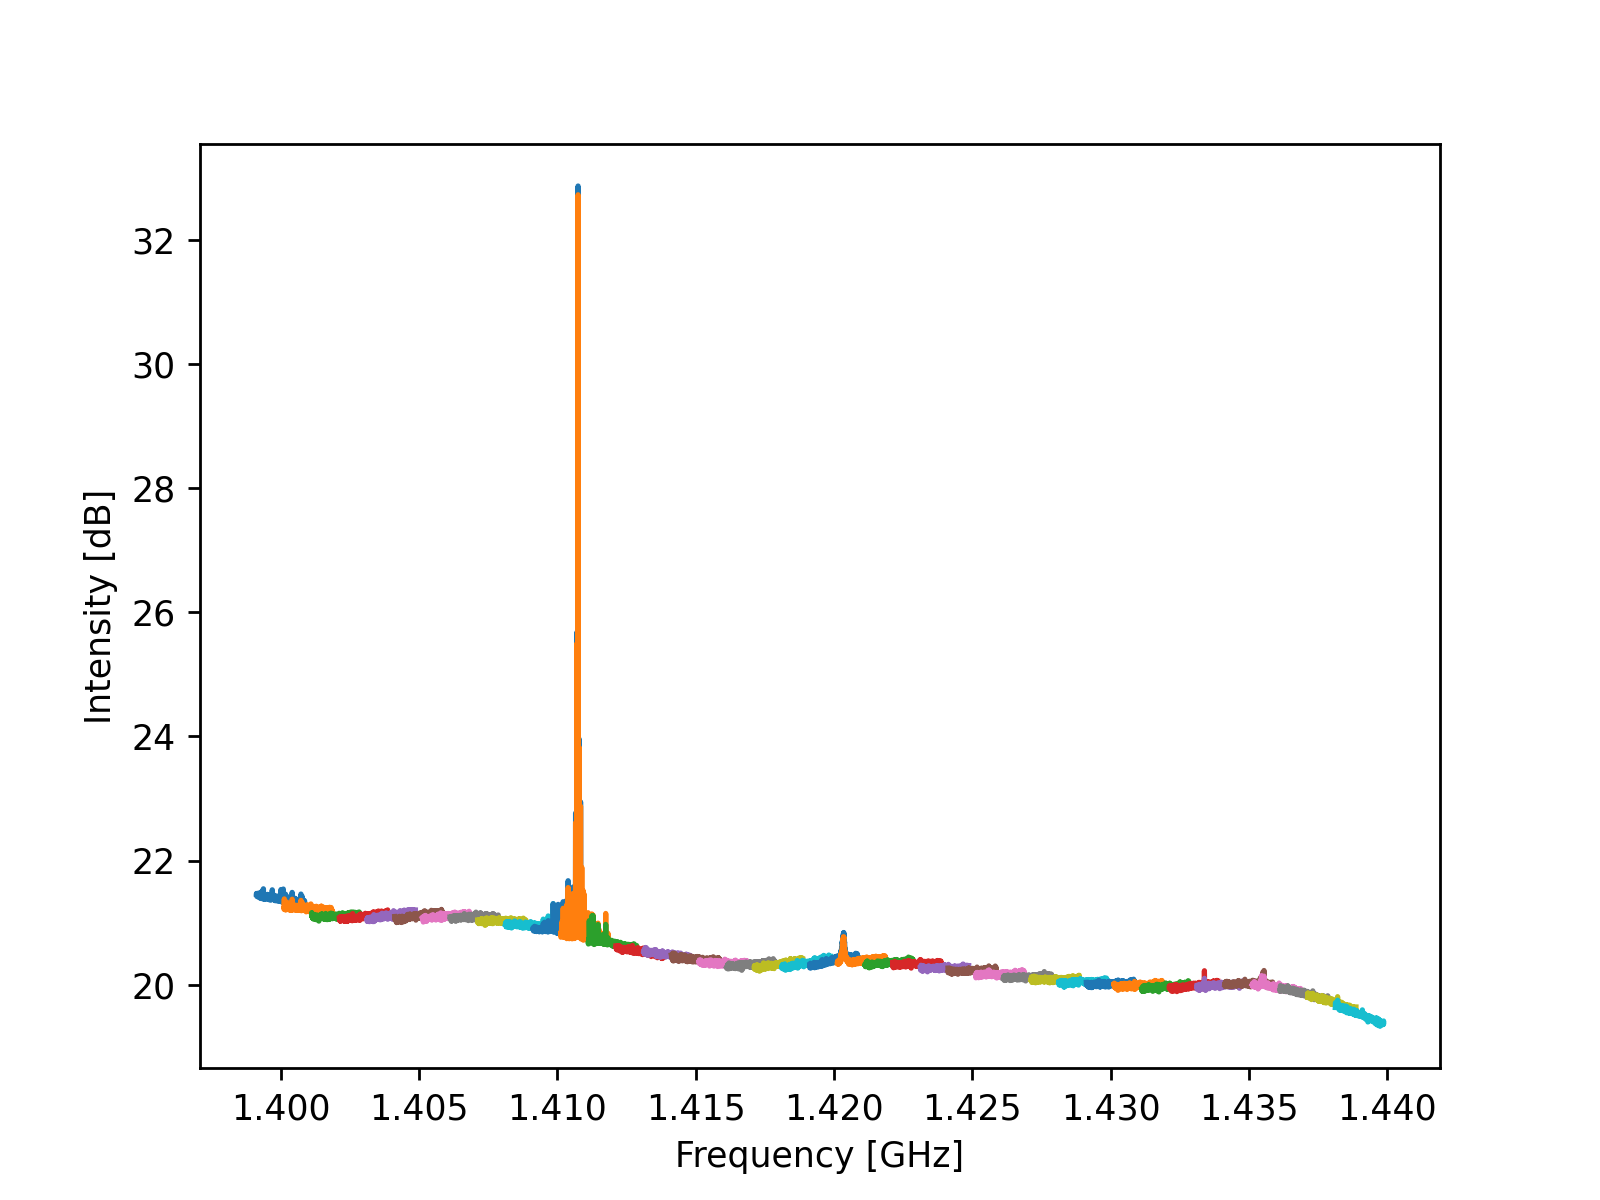

In [7]:
plt.figure('Calibrated spectra')
# The bandpass doesn't work great at the edges (low amplitude), so we remove some channels.
# This is ok because the files overlap!
nremove = nchans // 16

# These are lists that will store the spectra and frquency axes so we don't need to recalculate later.
spectra = []
freqs = []

for d, m in zip(data, meta):
    spectrum = np.mean(d, axis=0) / bp
    spectrum = spectrum[nremove:-nremove]
    if use_db:
        spectrum = 10 * np.log10(spectrum)
    frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                       * m['samp_rate'] / m['vector_length'] + m['frequency'])
    frequencies = 1e-9 * frequencies[nremove:-nremove]
    spectra.append(spectrum)
    freqs.append(frequencies)
    plt.plot(frequencies, spectrum)
    
plt.xlabel('Frequency [GHz]')
if use_db:
    plt.ylabel('Intensity [dB]')
else:
    plt.ylabel('Intensity [Arb. Units]')

This is looking much better! But there is still a choppiness. In theory, the same frequency should have the same amplitude between two files (unless there is any transient activity, which is a real possibility). But we see each file jumps relative to the next, so nothing lines up.

This is likely due to a changing gain in the electronics. This can come from an automatic gain control, where the radio decides the optimal amount of gain to give high sensitivity but avoid saturation, or (as in the Lost Dutchman case), the amplifier lost power as its battery drained.

In either case, let's try a quick fix to get rid of the choppiness. In the cell below we use some simple statistics to get the edges of the files to line up.

In [8]:
# Try to fix gain changes
# use last N points of one spectrum to match the first N of the next
for j in range(len(spectra) - 1):
    spec1 = spectra[j]
    spec2 = spectra[j + 1]
    freq1 = freqs[j]
    freq2 = freqs[j + 1]
    ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
    spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
    spectra[j + 1] = spec2

<IPython.core.display.Javascript object>


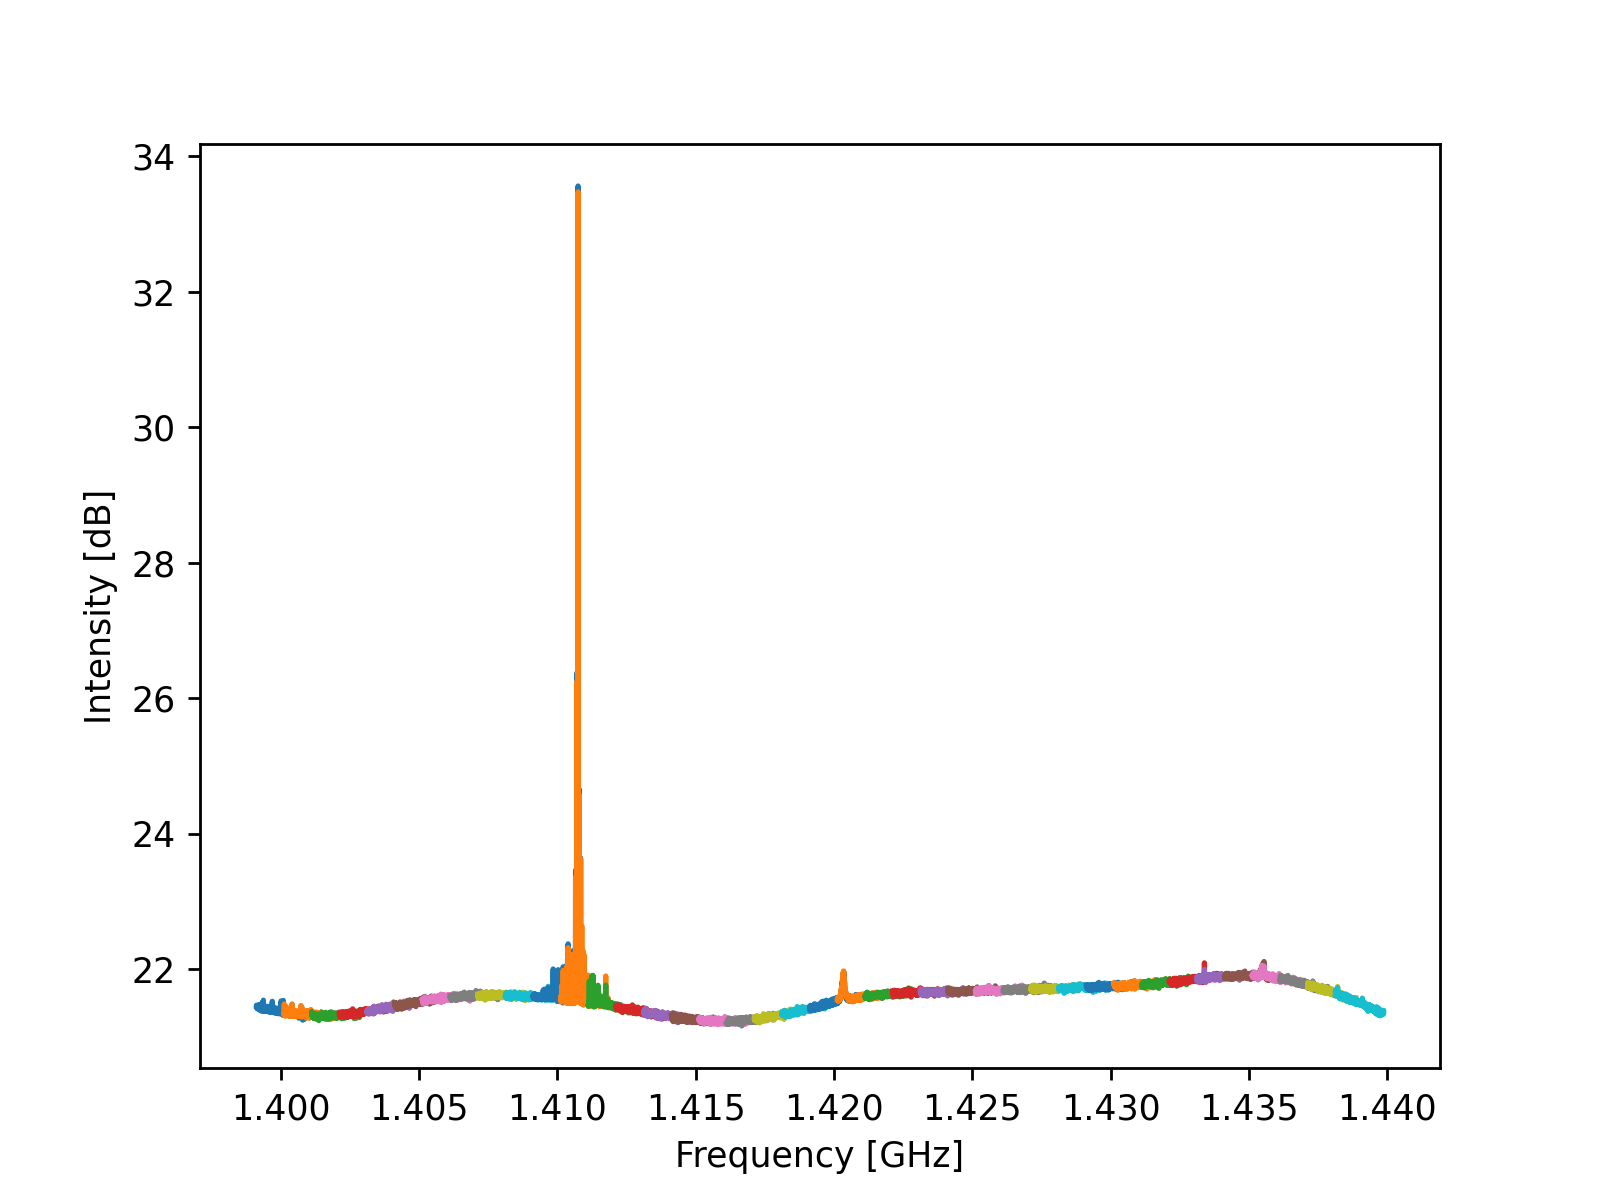

In [9]:
plt.figure('Spectra, more calibrated')
nremove = nchans // 16

for f, s in zip(freqs, spectra):
    plt.plot(f, s)

plt.xlabel('Frequency [GHz]')
if use_db:
    plt.ylabel('Intensity [dB]')
else:
    plt.ylabel('Intensity [Arb. Units]')